In [1]:
from typing import Optional, Union, Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
from numba import njit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Import data

In [2]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
mushroom = fetch_ucirepo(id=73)

In [3]:
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 

In [4]:
# variable information 
info = str(mushroom.variables[['name', 'role', 'type']]).split('\n')
desc = str(mushroom.variables[['description']]).split('\n')
full_info = ["\t".join([l_i, l_d[2:].strip()]) for l_i, l_d in zip(info, desc)]
print("\n".join(full_info))

                        name     role         type	description
0                  poisonous   Target  Categorical	None
1                  cap-shape  Feature  Categorical	bell=b,conical=c,convex=x,flat=f, knobbed=k,su...
2                cap-surface  Feature  Categorical	fibrous=f,grooves=g,scaly=y,smooth=s
3                  cap-color  Feature       Binary	brown=n,buff=b,cinnamon=c,gray=g,green=r, pink...
4                    bruises  Feature  Categorical	bruises=t,no=f
5                       odor  Feature  Categorical	almond=a,anise=l,creosote=c,fishy=y,foul=f, mu...
6            gill-attachment  Feature  Categorical	attached=a,descending=d,free=f,notched=n
7               gill-spacing  Feature  Categorical	close=c,crowded=w,distant=d
8                  gill-size  Feature  Categorical	broad=b,narrow=n
9                 gill-color  Feature  Categorical	black=k,brown=n,buff=b,chocolate=h,gray=g, gre...
10               stalk-shape  Feature  Categorical	enlarging=e,tapering=t
11        

# Check data

## Stats

In [5]:
y['poisonous'].value_counts()

poisonous
e    4208
p    3916
Name: count, dtype: int64

In [6]:
X_stats = X.describe().T
X_stats["nan"] = X.isna().sum()
X_stats

,count,unique,top,freq,nan
cap-shape,8124,6,x,3656,0
cap-surface,8124,4,y,3244,0
cap-color,8124,10,n,2284,0
bruises,8124,2,f,4748,0
odor,8124,9,n,3528,0
gill-attachment,8124,2,f,7914,0
gill-spacing,8124,2,c,6812,0
gill-size,8124,2,b,5612,0
gill-color,8124,12,b,1728,0
stalk-shape,8124,2,t,4608,0


## Density

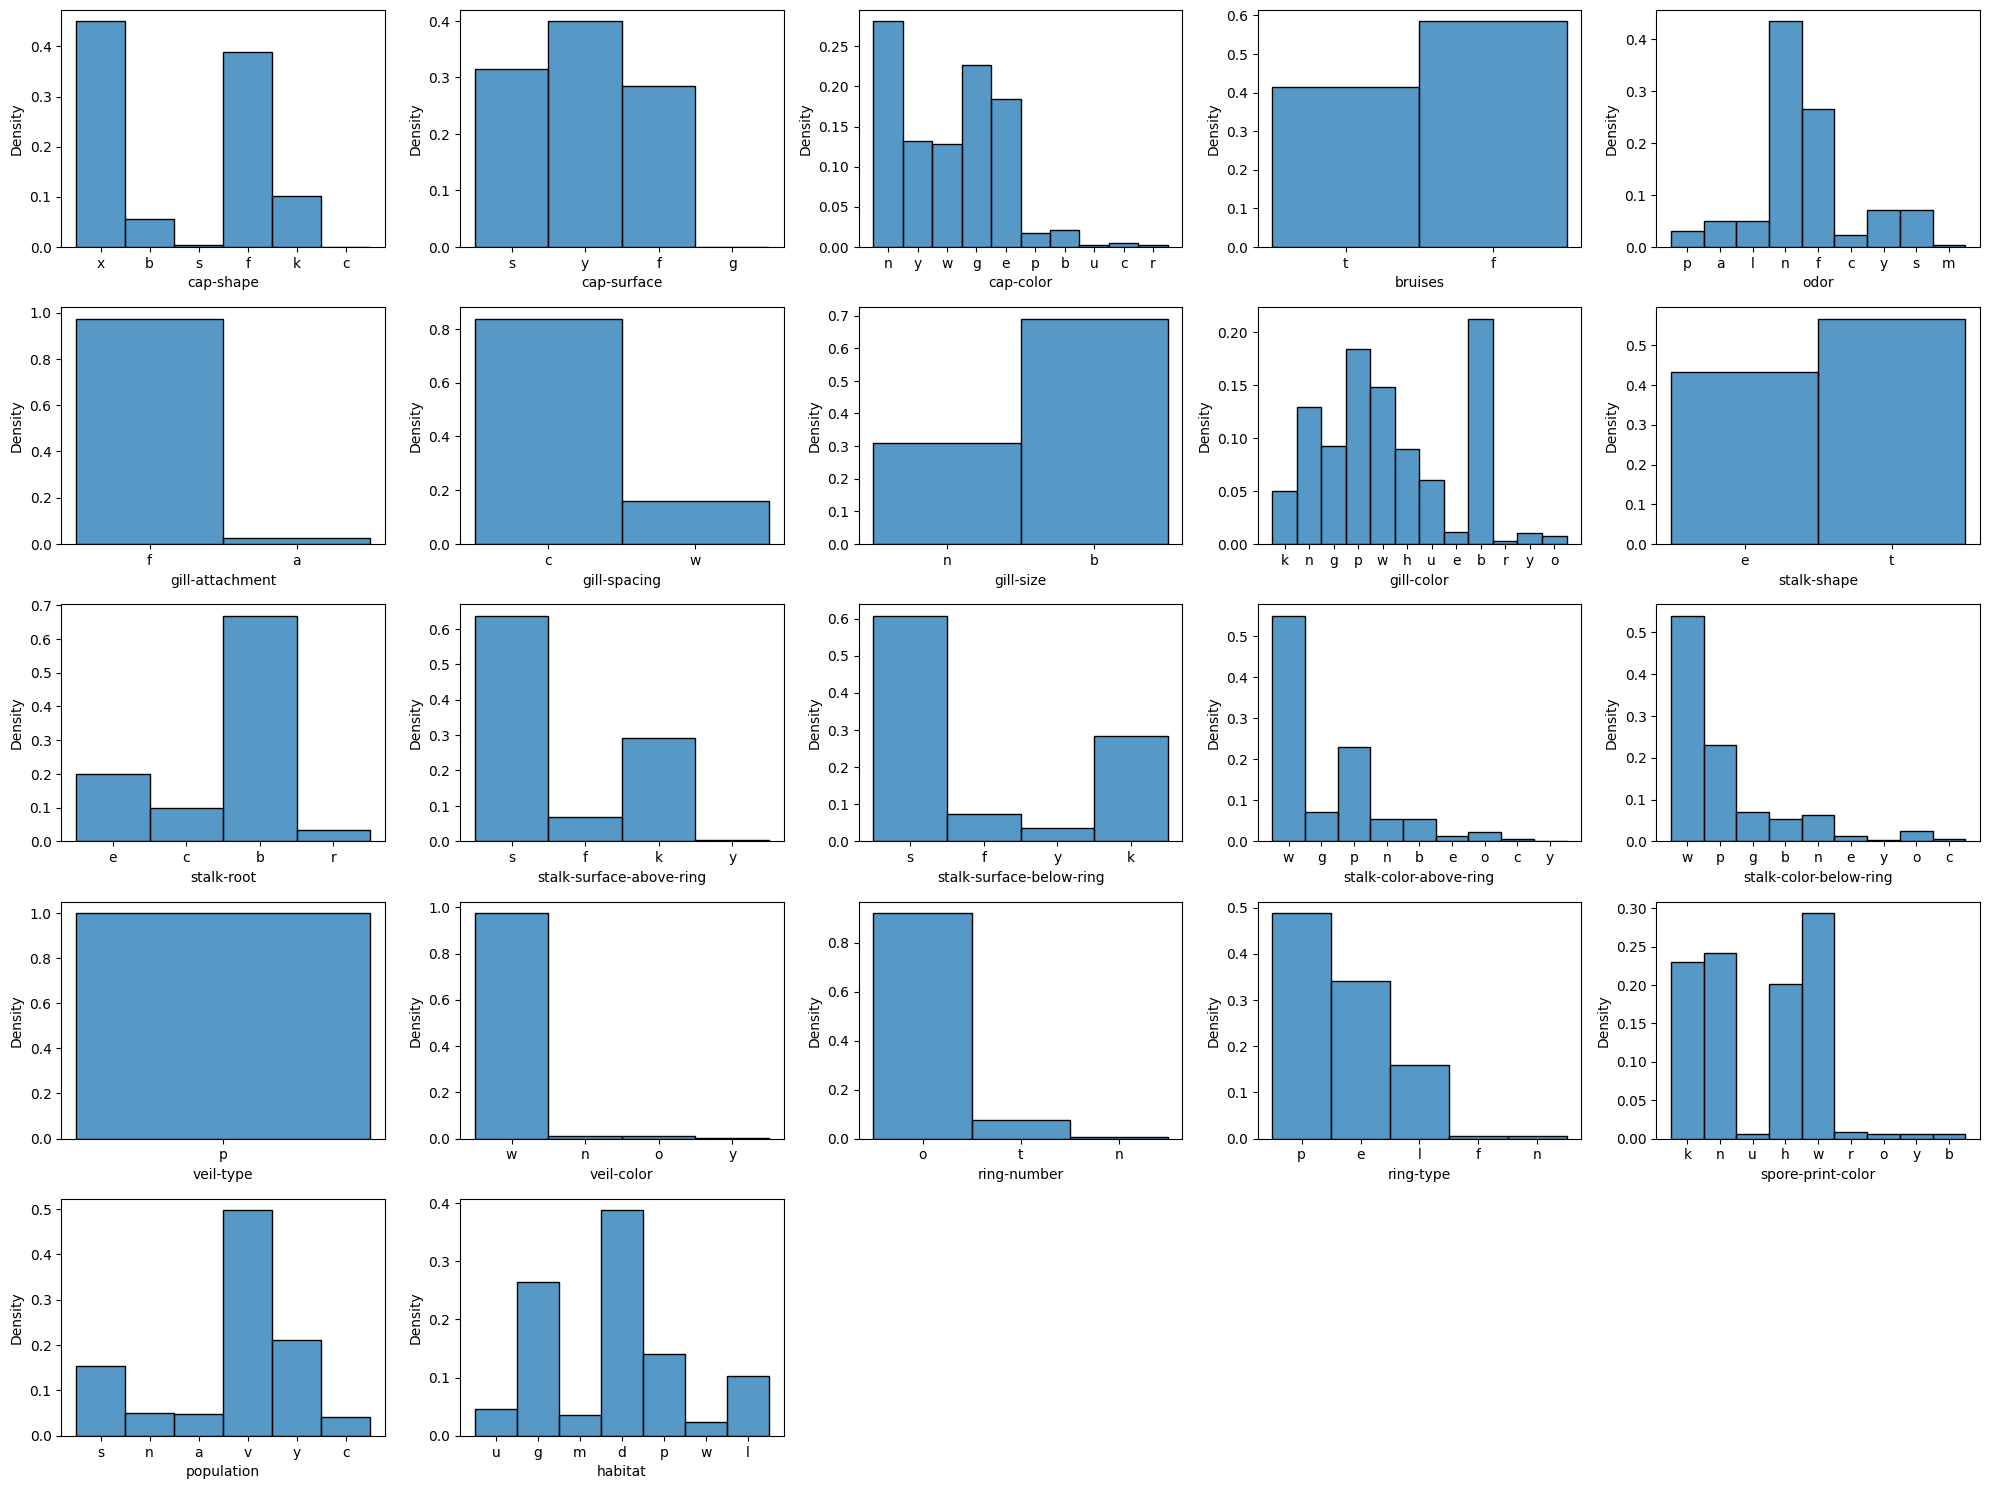

In [7]:
cnt_cols = len(X.columns)
_rows = int(np.ceil(np.sqrt(cnt_cols)))
_cols = int(np.ceil(cnt_cols / _rows))

plt.figure(figsize=(20, 15))

for i, col in enumerate(X.columns):
    plt.subplot(_rows, _cols, i + 1)
    sns.histplot(X[col], stat="density")

plt.tight_layout()
plt.show()

Исходя из увиденного сразу можно исключить признак veil-type - у него 1 уникальное значение

Также можно заметить, что у бинарного признака gill-attachment - 'f' преобладающее значение, возможно, можно удалить, либо сделать индикатор


## Features importance

In [8]:
df = X.copy()

le = LabelEncoder()

for column_name in df.columns:
    df[column_name] = le.fit_transform(df[column_name])

y_enc = le.fit_transform(y['poisonous'])

In [9]:
clf = RandomForestClassifier(criterion='entropy', random_state=41)
clf.fit(df, y_enc)

,n_estimators,100
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


<Axes: >

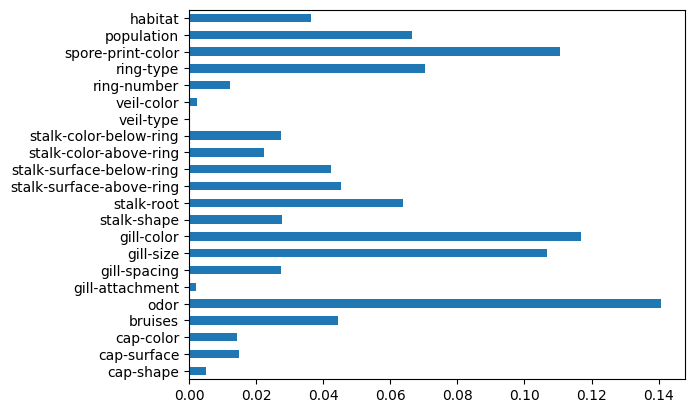

In [10]:
feat_importances = pd.Series(clf.feature_importances_, index=df.columns)
feat_importances.plot(kind='barh')

# Preprocess data

In [11]:
# Drop unnessesary feature

X = X.drop('veil-type', axis=1)
y = y['poisonous']

In [12]:
# Fill nan-s with mode
for feat in X_stats.index[X_stats['nan'] > 0]:
    feat_mode = X_stats.loc[feat]['top']
    X[feat] = X[feat].fillna(feat_mode)
    print(f"Filled {feat} with value '{feat_mode}'")

Filled stalk-root with value 'b'


In [13]:
# Encode targets to -1 / 1

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)  # 'e' -> 0, 'p' -> 1
y_encoded = y_encoded * 2 - 1 # 0 / 1 -> -1 / 1
print({cls: trg for cls, trg in zip(target_encoder.classes_, [-1, 1])})

{'e': -1, 'p': 1}


In [14]:
y_encoded = np.expand_dims(y_encoded, -1)
print(y_encoded.shape)

(8124, 1)


In [15]:
# One-Hot Encoding for features
onehot_encoder = OneHotEncoder(drop='first')
X_encoded = onehot_encoder.fit_transform(X).toarray()
print(X_encoded.shape)

(8124, 94)


In [16]:
# Split on train, val and test (63%, 7%, 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.3, 
    random_state=42,
    stratify=y_encoded
)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1, 
    random_state=15,
    stratify=y_train
)

In [18]:
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (5117, 94)
Val shape: (569, 94)
Test shape: (2438, 94)


# Modeling

## Common (utils)

In [19]:
def get_object(types_dict: Dict[str, type], obj: Union[str, object], base_type: type, default: str):
    if obj is None or isinstance(obj, str):
        obj = obj or default
        return types_dict[obj.lower()]()
    elif isinstance(obj, base_type):
        return obj
    else:
        raise RuntimeError(f"Param should be an instance of base {base_type}, string or None")

## Activation functions

In [20]:
# Base abstract Activation class

class Activation:
    NAME = None

    def call(self, x):
        raise NotImplementedError("Call not impelemted")

    def derivative(self, out):
        raise NotImplementedError("Derivative not impelemted")

    def __call__(self, x):
        return self.call(x)

    def __str__(self):
        return self.NAME

In [21]:
class Linear(Activation):
    NAME = "linear"

    def call(self, x):
        return x

    def derivative(self, out):
        return 1

In [22]:
class Sigmoid(Activation):
    NAME = "sigmoid"

    def __init__(self, clip_limit: Optional[Union[int, float]] = 250):
        self.clip_limit = -clip_limit if clip_limit is not None and clip_limit < 0 else clip_limit

    # @njit(cache=True,fastmath=True)
    def call(self, x):
        x = np.clip(x, -self.clip_limit, self.clip_limit) if self.clip_limit else x
        return 1 / (1 + np.exp(-x))

    # @njit(cache=True,fastmath=True)
    def derivative(self, out):
        return out * (1 - out)

In [23]:
class Tanh(Activation):
    NAME = "tanh"

    # @njit(cache=True,fastmath=True)
    def call(self, x):
        return np.tanh(x)

    def derivative(self, out):
        return 1. - out**2

In [24]:
# Find all classes based on Activation class
ACTIVATIONS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and Activation in v.__bases__
}

print(ACTIVATIONS)

{'linear': <class '__main__.Linear'>, 'sigmoid': <class '__main__.Sigmoid'>, 'tanh': <class '__main__.Tanh'>}


## Layers

In [25]:
class BaseLayer:
    def __init__(self, input_size, output_size, activation='linear'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = get_object(ACTIVATIONS, activation, base_type=Activation, default='linear')
        # Train params
        self.weights = None
        self.bias = None
        self.init_weights()

    def init_weights(self):
        raise NotImplementedError("Init weights not impelemted")

    @property
    def num_params(self):
        raise NotImplementedError("Number of parameters not impelemted")

    def forward(self, X):
        raise NotImplementedError("Forward not impelemted")

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def backward(self, X_transp, output, doutput):
        raise NotImplementedError("Backward not impelemted")

In [26]:
class Dense(BaseLayer):
    def init_weights(self):
        self.weights = np.random.normal(
            scale=2./(self.input_size + self.output_size), 
            size=(self.input_size, self.output_size)
        )
        self.bias = np.random.normal(
            scale=2/(self.input_size + self.output_size), 
            size=(1, self.output_size)
        )

    @property
    def num_params(self):
        return (self.input_size + 1) * self.output_size
    
    def forward(self, X):
        output = np.dot(X, self.weights) + self.bias
        output = self.activation(output)
        
        return output

    def __call__(self, X):
        return self.forward(X)

    def backward(self, X_transp, output, doutput):
        # Activation function gradient
        doutput = doutput * self.activation.derivative(output)
        # Next grdients calculation
        dinput = np.dot(doutput, self.weights.T)
        dweights = np.dot(X_transp, doutput)
        dbias = np.sum(doutput, axis=0, keepdims=True)

        return dinput, {"weights": dweights, "bias": dbias}

## Optimizers

In [27]:
class BaseOptimizer:
    NAME = None

    def apply_gradients(self, layer: BaseLayer, grads: Dict[str, np.array]):
        for _weights_name, _weights_grad in grads.items():
            weights = getattr(layer, _weights_name, None)
            if weights is None:
                continue
            setattr(layer, _weights_name, self._grad_step(weights, _weights_grad))

    def _grad_step(self, weights, grads):
        raise NotImplementedError("Applying gradients not impelemted")

In [28]:
class SimpleOptimizer(BaseOptimizer):
    NAME = "simple"

    def __init__(self, learning_rate: float = 1e-4):
        self.lr = learning_rate

    def _grad_step(self, weights, grads):
        return weights - self.lr * grads

In [29]:
# Find all classes based on Activation class
OPTIMIZERS = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseOptimizer in v.__bases__
}

print(OPTIMIZERS)

{'simple': <class '__main__.SimpleOptimizer'>}


## Losses

In [30]:
class BaseLoss:
    NAME = None

    def __init__(self):
        self.history = []
        self.val_history = []
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def calc(self, y_true, y_pred):
        raise NotImplementedError("Loss calc not impelemted")

    def derivative(self, y_true, y_pred):
        raise NotImplementedError("Loss derivative not impelemted")

    def batch_loss(self):
        if self.epoch_loss is not None and self.epoch_batch_cnt > 0:
            return self.epoch_loss / self.epoch_batch_cnt
        return None

    def _update_history(self):
        batch_loss = self.batch_loss()
        if batch_loss is not None:
            self.history.append(batch_loss)

    def start_epoch(self):
        self._update_history()
        self.epoch_loss = 0
        self.epoch_batch_cnt = 0

    def update_epoch(self, y_true, y_pred):
        loss = self.calc(y_true, y_pred)
        self.epoch_loss += loss
        self.epoch_batch_cnt += 1

    def end_epoch(self):
        self._update_history()
        self.epoch_loss = None
        self.epoch_batch_cnt = 0

    def val_loss(self, y_true, y_pred):
        loss = self.calc(y_true, y_pred)
        self.val_history.append(loss)
        return loss

    def __call__(self, y_true, y_pred):
        return self.calc(y_true, y_pred)

In [31]:
class MSE(BaseLoss):
    NAME = 'mse'

    def calc(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

    def derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.shape[0]

In [32]:
# Find all classes based on Activation class
LOSSES = {
    v.NAME: v 
    for v in globals().values() 
    if isinstance(v, type) and BaseLoss in v.__bases__
}

print(LOSSES)

{'mse': <class '__main__.MSE'>}


## Model

In [33]:
class Model:
    def __init__(self, layers: Optional[List[BaseLayer]] = None):
        self.layers = layers or []

        self.epoch = None
        self.verbose = 1

    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def compile(self, loss='mse', optimizer='simple'):            
        self.loss = get_object(LOSSES, loss, base_type=BaseLoss, default='mse')
        self.optimizer = get_object(OPTIMIZERS, optimizer, base_type=BaseOptimizer, default='simple')

    def _train_iter(self, layer_input, y, layer_ind: int = 0):
        if layer_ind >= len(self.layers):
            y_pred = layer_input
            self.loss.update_epoch(y, y_pred)
            dloss = self.loss.derivative(y, y_pred)
            return dloss

        layer = self.layers[layer_ind]
        output = layer(layer_input)
        # Next layer process
        doutput = self._train_iter(output, y, layer_ind + 1)
        # Backward step
        dinput, updates = layer.backward(layer_input.T, output, doutput)
        # Otimizer apply gradients
        self.optimizer.apply_gradients(layer, updates)
        return dinput

    def train_step(self, X, y, batch_size):
        n_batches = int(np.ceil(X.shape[0] / batch_size))

        for batch in range(n_batches):
            # Get mini-batch
            batch_st, batch_end = batch * batch_size, (batch + 1) * batch_size
            X_batch, y_batch = X[batch_st:batch_end], y[batch_st:batch_end]
            # Train iteration
            self._train_iter(X_batch, y_batch)

            if self.verbose > 0:
                print(f"\rBatch {batch + 1}/{n_batches}, Loss: {self.loss.batch_loss():.4f}", end="")

    def fit(self, X, y, X_val=None, y_val=None, epochs=100, batch_size=32, verbose=1):
        self.verbose = verbose or 0
        n_samples = X.shape[0]

        for epoch in range(epochs):
            self.epoch = epoch
            # Shuffle data
            # indices = np.random.permutation(n_samples)
            # X_shuffled, y_shuffled = X[indices], y[indices]

            self.loss.start_epoch()
            self.train_step(X, y, batch_size)
            self.loss.end_epoch()

            if X_val is not None and y_val is not None:
                val_loss = self.loss.val_loss(y_val, self.predict(X_val))
            else:
                val_loss = None
    
            if self.verbose > 0:
                val_str = "" if val_loss is None else f", Val. Loss: {val_loss:.4f}"
                print(f"\rEpoch {self.epoch + 1}/{epochs}, Epoch Loss: {self.loss.history[-1]:.4f}{val_str}")

        if X_val is not None and y_val is not None:
            return self.loss.history, self.loss.val_history
        else:
            return self.loss.history

    def predict(self, X):
        return self.forward(X)

    def summary(self):
        # Collect info
        info = [ # Header
            ["Layer", "Input size", "Output size", "Num params", "Activation"]
        ]
        info_len = list(map(len, info[0]))
        for layer in self.layers:
            layer_info = (
                layer.__class__.__name__, 
                layer.input_size,
                layer.output_size,
                layer.num_params,
                layer.activation,
            )
            layer_info = list(map(str, layer_info))
            info.append(layer_info)
            
            layer_lens = list(map(len, layer_info))
            info_len = [max(_prev, _new) for _prev, _new in zip(info_len, layer_lens)]
        # Print info
        def _print_dash_line():
            print("+", end="")
            for _len in info_len:
                print("-" * (_len + 2), end="+")
            print()

        print("Model summary")
        _print_dash_line()
        for row_ind, row_info in enumerate(info):
            print("| ", end="")
            for field, field_len in zip(row_info, info_len):
                print(field.ljust(field_len), end=" | ")
            print()
            if row_ind == 0 or row_ind == len(info) - 1:
                _print_dash_line()

## Metrics

In [34]:
def plot_hist(train_history, val_history=None):
    plt.plot(train_history, c='b', label="Train")
    if val_history is not None:
        plt.plot(val_history, c='r', label="Validation")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [35]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    return pd.DataFrame(
        [[tp, fp], [fn, tn]], 
        columns=pd.MultiIndex.from_tuples([("Actual", "Positive"), ("Actual", "Negative")]),
        index=pd.MultiIndex.from_tuples([("Predict", "Positive"), ("Predict", "Negative")])
    )

def precision_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [36]:
from scipy.integrate import trapezoid

def roc_curve(y_true, y_score):
    y_true = y_true == 1

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true, dtype=np.float64)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    fpr = fps / fps[-1]
    tpr = tps / tps[-1]
    return fpr, tpr, y_score[threshold_idxs]

def auc(fpr, tpr):
    area = trapezoid(tpr, fpr)
    return float(area)

In [37]:
def get_predict_classes(y_pred, threshold: float = 0.0):
    return np.where(y_pred >= threshold, 1, -1)

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1

def evaluate_model(model, X_test, y_test, threshold: float = 0.0):
    y_pred = model.predict(X_test)
    y_pred = get_predict_classes(y_pred, threshold=threshold)

    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return confusion_matrix(y_test, y_pred)

# Training

In [50]:
# Hyperparams

LEARNING_RATE = 1e-2

In [55]:
# Model params
input_size = X_train.shape[1]
hidden_layers_units = [200, 100]
output_units = 1

# Create model with all hidden layers
model = Model([
    Dense(_input_units, _output_units, activation='sigmoid')
    for _input_units, _output_units in zip([input_size] + hidden_layers_units[:-1], hidden_layers_units)
])
# Output layer (tanh activation)
model.add(Dense(hidden_layers_units[-1], output_units, activation='tanh'))

model.summary()

Model summary
+-------+------------+-------------+------------+------------+
| Layer | Input size | Output size | Num params | Activation | 
+-------+------------+-------------+------------+------------+
| Dense | 94         | 200         | 19000      | sigmoid    | 
| Dense | 200        | 100         | 20100      | sigmoid    | 
| Dense | 100        | 1           | 101        | tanh       | 
+-------+------------+-------------+------------+------------+


In [56]:
# Set loss and optimizer
model.compile(
    loss='mse', 
    optimizer=SimpleOptimizer(learning_rate=LEARNING_RATE)
)

In [57]:
train_history, val_history = model.fit(
    X_train, y_train, 
    X_val, y_val,
    epochs=400,
    batch_size=64
)

Epoch 1/400, Epoch Loss: 1.0057, Val. Loss: 1.0016
Epoch 2/400, Epoch Loss: 1.0053, Val. Loss: 1.0016
Epoch 3/400, Epoch Loss: 1.0053, Val. Loss: 1.0016
Epoch 4/400, Epoch Loss: 1.0052, Val. Loss: 1.0016
Epoch 5/400, Epoch Loss: 1.0052, Val. Loss: 1.0016
Epoch 6/400, Epoch Loss: 1.0052, Val. Loss: 1.0015
Epoch 7/400, Epoch Loss: 1.0051, Val. Loss: 1.0015
Epoch 8/400, Epoch Loss: 1.0051, Val. Loss: 1.0015
Epoch 9/400, Epoch Loss: 1.0051, Val. Loss: 1.0015
Epoch 10/400, Epoch Loss: 1.0050, Val. Loss: 1.0015
Epoch 11/400, Epoch Loss: 1.0050, Val. Loss: 1.0014
Epoch 12/400, Epoch Loss: 1.0050, Val. Loss: 1.0014
Epoch 13/400, Epoch Loss: 1.0049, Val. Loss: 1.0014
Epoch 14/400, Epoch Loss: 1.0049, Val. Loss: 1.0014
Epoch 15/400, Epoch Loss: 1.0049, Val. Loss: 1.0014
Epoch 16/400, Epoch Loss: 1.0048, Val. Loss: 1.0013
Epoch 17/400, Epoch Loss: 1.0048, Val. Loss: 1.0013
Epoch 18/400, Epoch Loss: 1.0048, Val. Loss: 1.0013
Epoch 19/400, Epoch Loss: 1.0047, Val. Loss: 1.0013
Epoch 20/400, Epoch L

# Model metrics

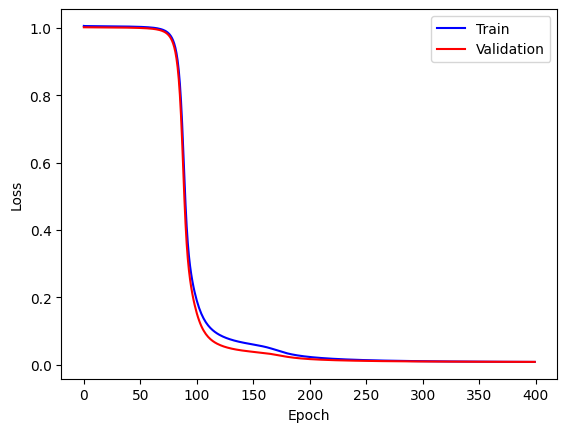

In [58]:
plot_hist(train_history, val_history)

In [59]:
# Eval model on test
evaluate_model(model, X_test, y_test)

Accuracy: 0.9971
Precision: 1.0000
Recall: 0.9940
F1-Score: 0.9970


Actual         
                 Positive Negative
Predict Positive     1168        0
        Negative        7     1263

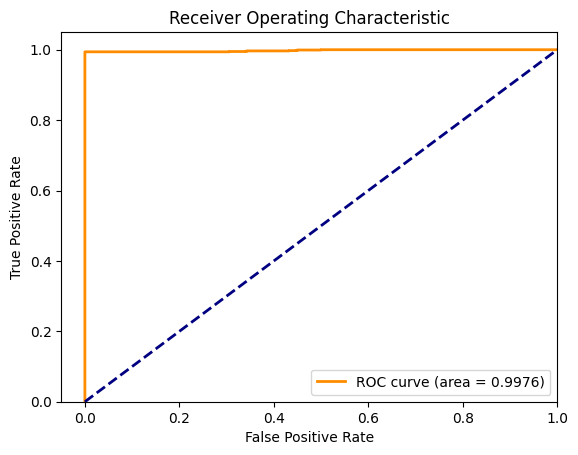

In [60]:
# ROC-AUC
y_pred_proba = model.predict(X_test)[:, 0]
fpr, tpr, thr = roc_curve(y_test[:, 0], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()